In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
#from module import *
%matplotlib inline
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")

## Traspoizione dei dati
Prima di iniziare dobbiamo trasporre le tabelle dei dati in modo che siano passabili agli algoritmi di Clustering. Le "features" dovranno essere le lunghezze d'onda dei dati.

In [3]:
#definisco i nomi da assegnare ai punti delli spettri di sampling
#wn -> wave number  r -> row c -> columns
names = ['wn']+[f'r{k}c{i}' for k in range(1,12) for i in range(1,12)]

In [4]:
# import dei "normalized data without offset"
data = pd.read_csv("../data/processed/EDA_processed_data.csv")
# import dei dati senza rumore  ("nn" --> no noise)
data_nn = pd.read_csv("../data/processed/EDA_processed_data_wnb.csv")

**Per poter usare il nostro algoritmo dobbiamo traspore il database, usando le lunghezze d'onda come features.**

In [5]:
data_t = data.transpose()
new_header = data_t.iloc[1] #grab the first row for the header
data_t = data_t[2:]
data_t.columns = new_header #set the header row as the df header
data_t.head()


wn,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,...,1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0
r1c1,0.000122,0.000233,0.000247,0.000202,0.000015,-0.000092,-0.000235,-0.000359,-0.000355,-0.000359,...,-0.000121,0.000042,0.000070,0.000083,0.000047,-0.000019,-0.000164,-0.000233,-0.000186,0.000020
r1c2,-0.000049,-0.000053,-0.000060,-0.000074,-0.000101,-0.000116,-0.000137,-0.000162,-0.000174,-0.000179,...,-0.000252,-0.000203,-0.000206,-0.000214,-0.000226,-0.000232,-0.000233,-0.000232,-0.000234,-0.000220
r1c3,0.000013,0.000068,0.000095,0.000169,0.000338,0.000405,0.000539,0.000715,0.000770,0.000908,...,0.000143,0.000198,0.000157,0.000051,-0.000050,-0.000034,0.000043,0.000119,0.000150,0.000208
r1c4,-0.000187,0.000087,0.000141,0.000141,-0.000003,-0.000106,-0.000230,-0.000318,-0.000293,-0.000203,...,-0.000229,-0.000235,-0.000208,-0.000156,-0.000116,-0.000137,-0.000199,-0.000231,-0.000208,-0.000131
r1c5,-0.000671,-0.000473,-0.000425,-0.000353,-0.000251,-0.000247,-0.000232,-0.000217,-0.000233,-0.000222,...,-0.000008,-0.000107,-0.000135,-0.000169,-0.000170,-0.000122,-0.000004,0.000067,0.000050,-0.000035


In [6]:
data_nnt = data_nn.transpose()
new_header = data_nnt.iloc[1] #grab the first row for the header
data_nnt = data_nnt[2:]
data_nnt.columns = new_header #set the header row as the df header

## Tentativo di clustering con DBSCAN
Tentiamo quì un clustering con l'algoritmo DBSCAN visto a lezione. 

Ci accorgiamo subito di un problema nell'utilizzare questo algoritmo che si basa sulla densità: per concentrazioni diverse di materiali nel punto in cui si fa lo spettro Raman (che chiaramente possono variare in modo contiunuo) corrispondono spettri Raman diversi, ed anche questi variano in modo continuo. 

Il clustering dunque non è ben definito dato che abbiamo picchi che variano in modo continuo da un'altezza x a zero in spettri diversi. 

Un'algoritmo come DBSCAN che clusterizza utilizzando la densità, presi degli spettri raman di materiale composto da slicio e quarzo, metterà nello stesso cluster uno spettro corrispondente a 100% quarzo, uno 70% quarzo e 30% silicio e così via fino a 100% silicio se ci sono spettri sufficienti per riempire in modo continuo la transizione tra questi due materiali. 

Come vediamo di seguito l'algoritmo unisce spettri sensibilmente diversi con picchi che vanno dal loro valore massimo a zero.

### Clustering dei dati rumorosi
Effettuiamo quì un clustering con DBScan ai dati rumorosi. Il cluster -1 rappresenta i dati che l'algoritmo, con densità fissata e numero minimo di punti per formare un cluster, non è riuscito a clusterizzare.

In [7]:
cluster_DB = DBSCAN(eps=0.02, min_samples=2)
cluster_DB.fit(data_t)
label = cluster_DB.labels_

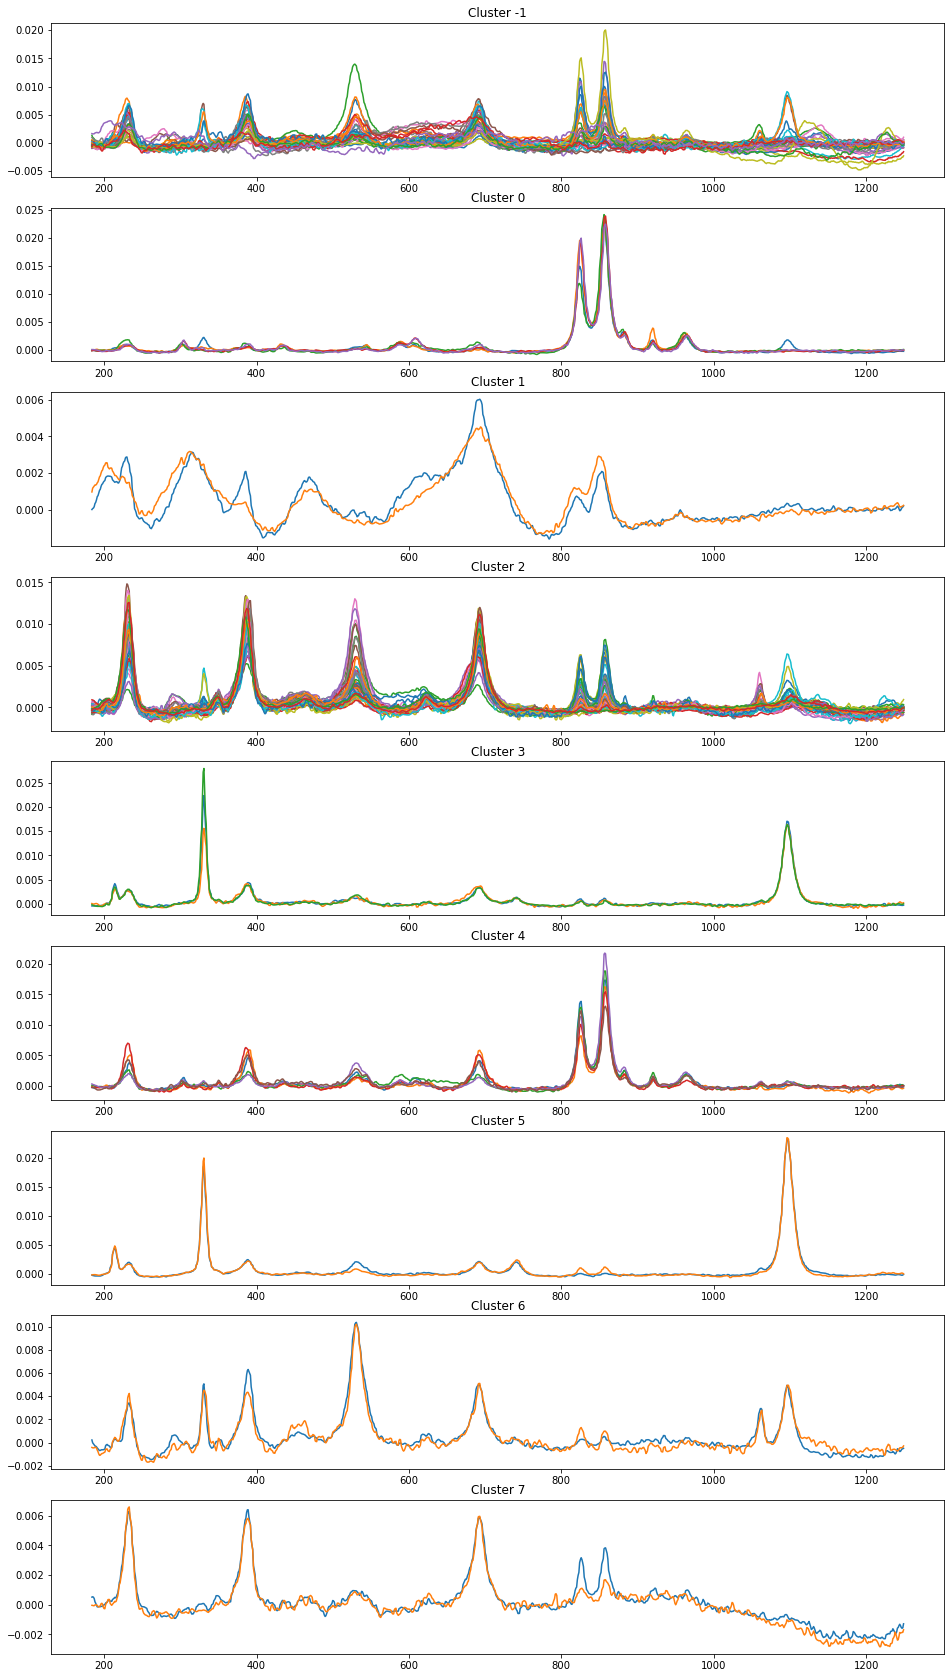

In [8]:
fig1, axs1 = plt.subplots(len(np.unique(label)),figsize = (16,30))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label)):
    for temp in enumerate(label):
        if temp[1]==i[1]:
            axs1[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs1[i[0]].set_title('Cluster ' + str(i[1]))

## Clustering con KMEANS
Abbiamo capito dunque che il clustering non è ben definito, nel senso che non è univoco il modo in cui possiamo definire materiali diversi, dato che le abbondanze variano in modo continuo.

Un algoritmo che non si basà sulle densità ci sembra dunque più adeguato dato che permette di distinguere concentrazioni diverse (scegliendo un bound per la dimensione dei cluster o, come in questo caso, scegliendo il numero di cluster).

Utilizziamo quì KMEANS, algoritmo visto a lezione. 

Il vantaggio è che questo non "insegue" parti continue dei cluster ma si limita a disegnare sfere nello spazio delle features minimizzando la varianza del cluster, proprio ciò che ci serve! 

Di seguito vediamo come lavora:

In [9]:
cluster_t_KM = KMeans(n_clusters=7,max_iter=6000,tol=0.00001)
cluster_t_KM.fit(data_t)
label_t = cluster_t_KM.labels_

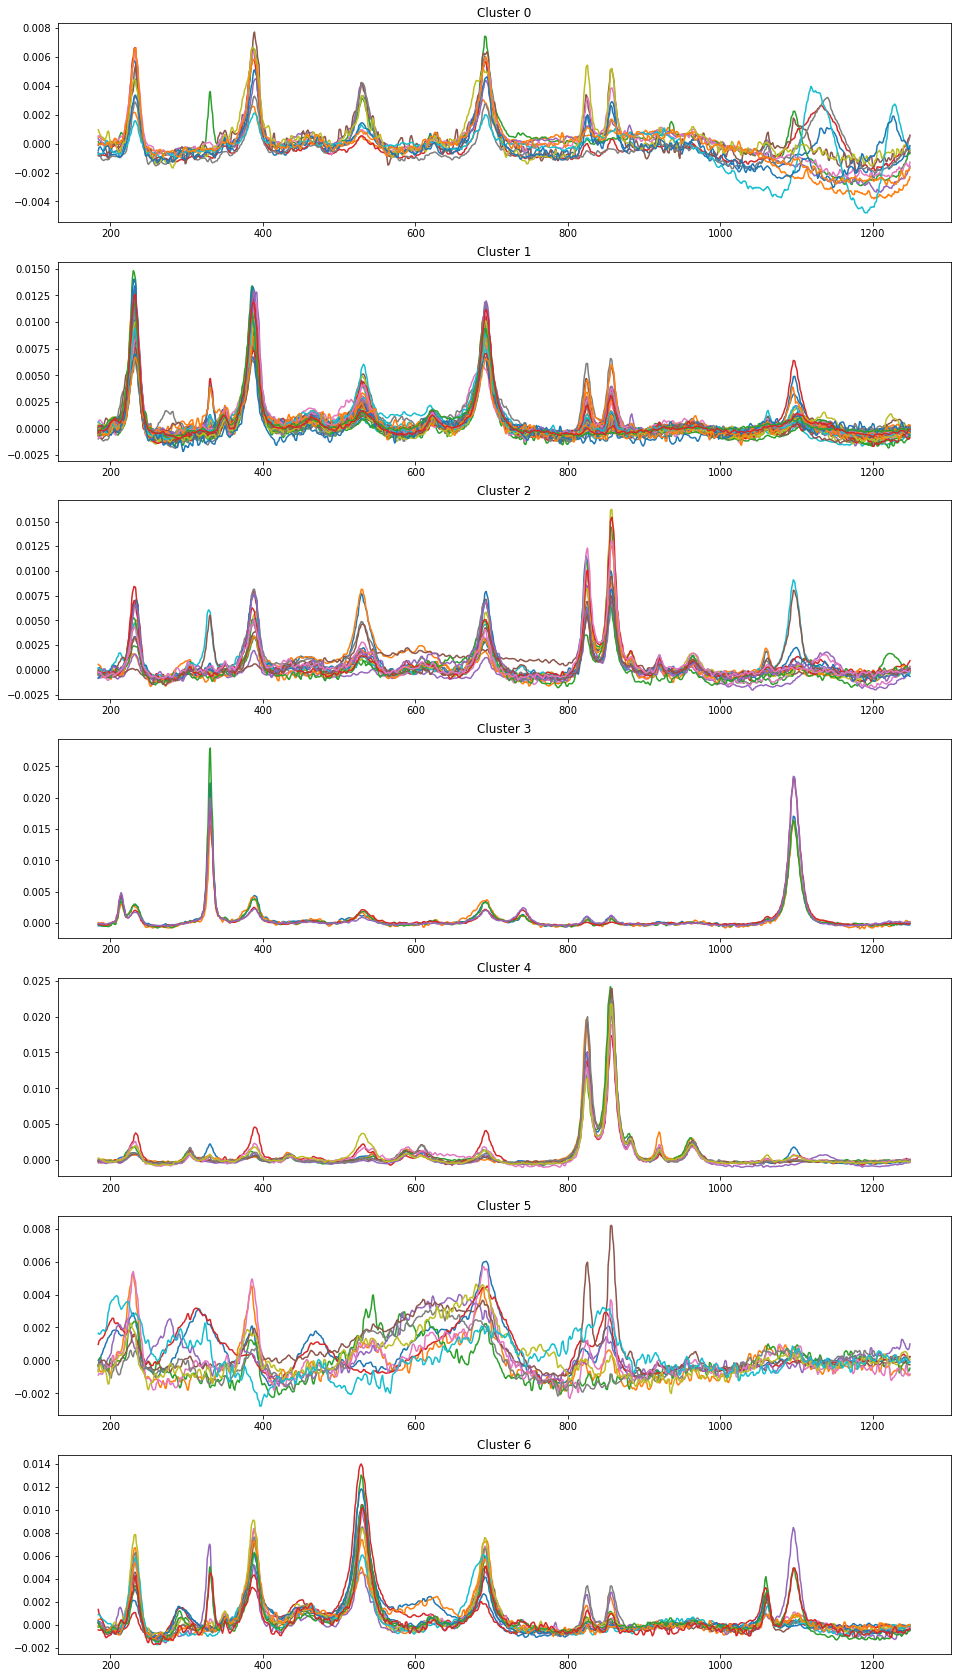

In [10]:
fig2, axs2 = plt.subplots(len(np.unique(label_t)),figsize = (16,30))
#fig.suptitle("Plot dei vari cluster, asse x: numero d'onda. asse y: intensita'")
for i in enumerate(np.unique(label_t)):
    for temp in enumerate(label_t):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))

E di seguito il plot dei centri del clustering. 

Notiamo immediatamente come questo metodo rimuova il rumore dato che stiamo mediando su un gran numero di spettri, questo ci tornerà molto utile.

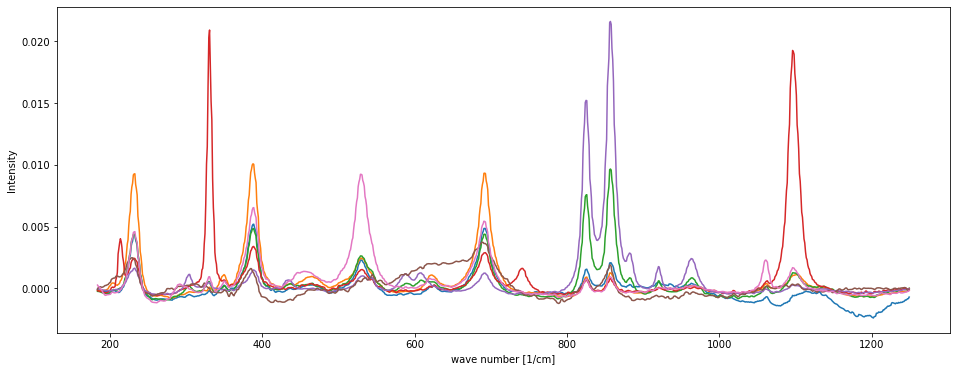

In [11]:
raman_plot()
for temp in np.unique(label_t):
    plt.plot(data.wn,cluster_t_KM.cluster_centers_[temp])

**Ora dobbiamo decidere come scegliere il numero di cluster.**
La consegna ci chiede prima di guardare se il clustering correla con la posizione, poi di fittare gli spettri del campione a quelli puri.

Faremo diverse scelte del numero di cluster per i due casi.

## Il risultato del clustering correla con la posizione?
A questo scopo vogliamo plottare i cluster su una griglia, in modo che l'impatto visivo sia efficace scegliamo un numero piccolo di cluster. 

**Questa scelta equivale a ritenere uguali materiali con abbondanze diverse.** 

Scegliamo di utilizzare 6 cluster.

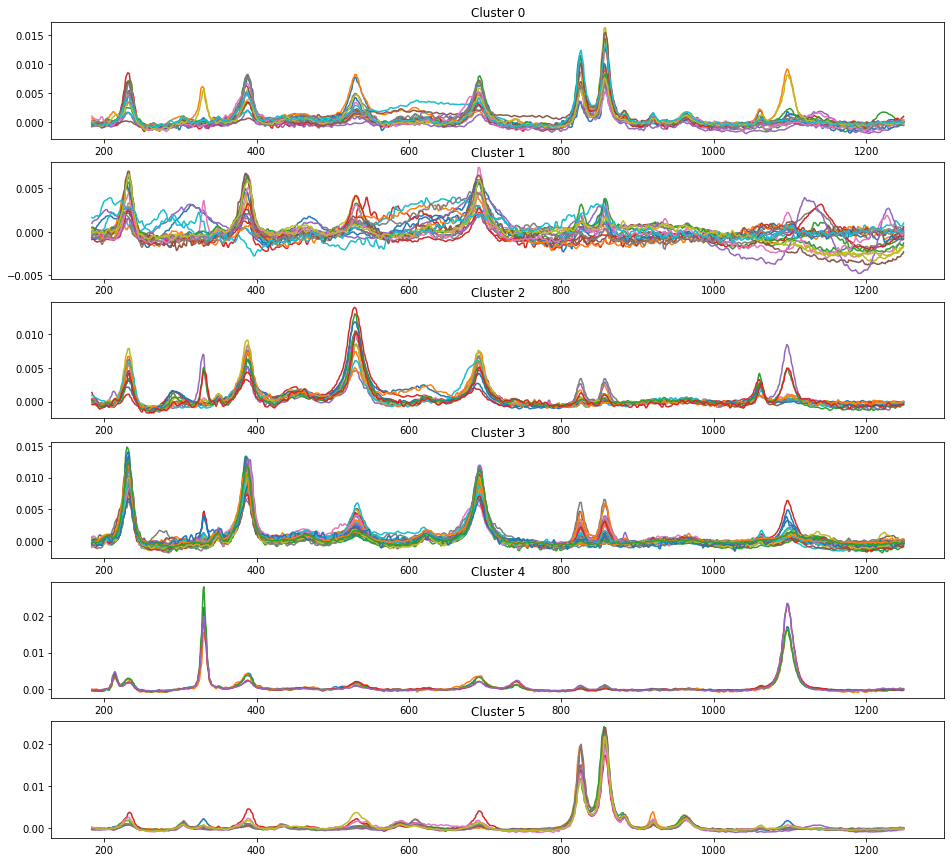

In [12]:
cluster_KM = KMeans(n_clusters=6,max_iter=6000,tol=0.0001)
cluster_KM.fit(data_t)
label = cluster_KM.labels_
fig2, axs2 = plt.subplots(len(np.unique(label)),figsize = (16,15))
for i in enumerate(np.unique(label)):
    for temp in enumerate(label):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))

Facciamo un plot per vedere se i cluster trovati correlano con la posizione. 

Visivamente si vede come la correlazione tra posizione e cluster sia presente.

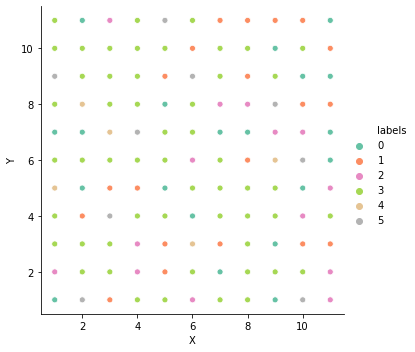

In [13]:
XX=list((np.array(range(11))+1))*11
YY=[]

for i in range(11):
    YY.extend(list(np.ones(11)*(i+1)))
    
d = {'X': XX, 'Y': YY,'labels':label}

grid = pd.DataFrame(data=d)

sns.relplot(
    data=grid,
    x="X", y="Y",
    hue="labels",
    palette=("Set2"),
    legend = "full"
);

### Definizione di correlazione spaziale

## Come scegliere il numero di cluster?
Vogliamo utilizzare la clasterizzazione per rimuovere il rumore dagli spettri, mediando sul cluster.

Per scegliere il numero di cluster andiamo a vedere come varia l'errore della clusterizzazione al variare del numero di cluster(attributo "inertia" della classe KMeans). 

Come abbiamo visto a lezione ci aspettiamo una zona a decrescenza a rapida e una a decrescenza più lenta.

In [14]:
cluster_KM = KMeans(n_clusters=6,max_iter=6000,tol=1e-4)
cluster_KM.fit(data_t);

Text(0, 0.5, 'Inertia')

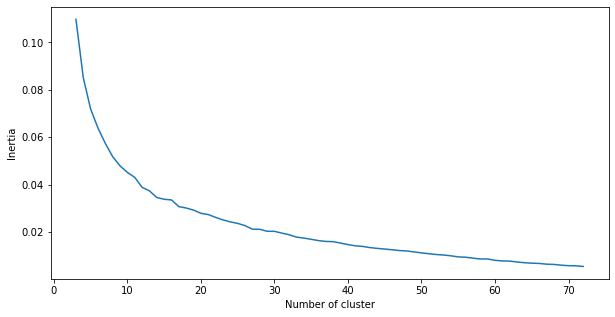

In [15]:
q=70 #number of trys
inertia=[]
for i in range(q):
    a=i+3
    cluster_KM = KMeans(n_clusters=a,max_iter=6000,tol=1e-4)
    cluster_KM.fit(data_t)
    inertia.append(cluster_KM.inertia_)
plt.figure(figsize=(10,5))
plt.plot(list(np.array(range(q))+3),inertia);
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")

Dal plot si distingue chiaramente la zona a decrescenza rapida da quella a decrescenza più lenta.

Scegliamo come numero di cluster quello con la pendenza intorno al 20.

Calcoliamo la derivata in quel punto.

In [16]:
derivata=(inertia[20-3]-inertia[19-3])
derivata

-0.0013601627263536697

L'algoritmo che sceglie quando fermarsi usando questà derivata come soglia sarà il seguente.

In [17]:
derivata=abs(derivata)
cluster_KM = KMeans(n_clusters=4,max_iter=6000,tol=1e-4)
cluster_KM.fit(data_t)
temp=derivata+1 
i=5
while temp>derivata:
    a=cluster_KM.inertia_
    cluster_KM = KMeans(n_clusters=i,max_iter=600,tol=1e-4)
    cluster_KM.fit(data_t)
    b=cluster_KM.inertia_
    temp=a-b
    i+=1
label=cluster_KM.labels_

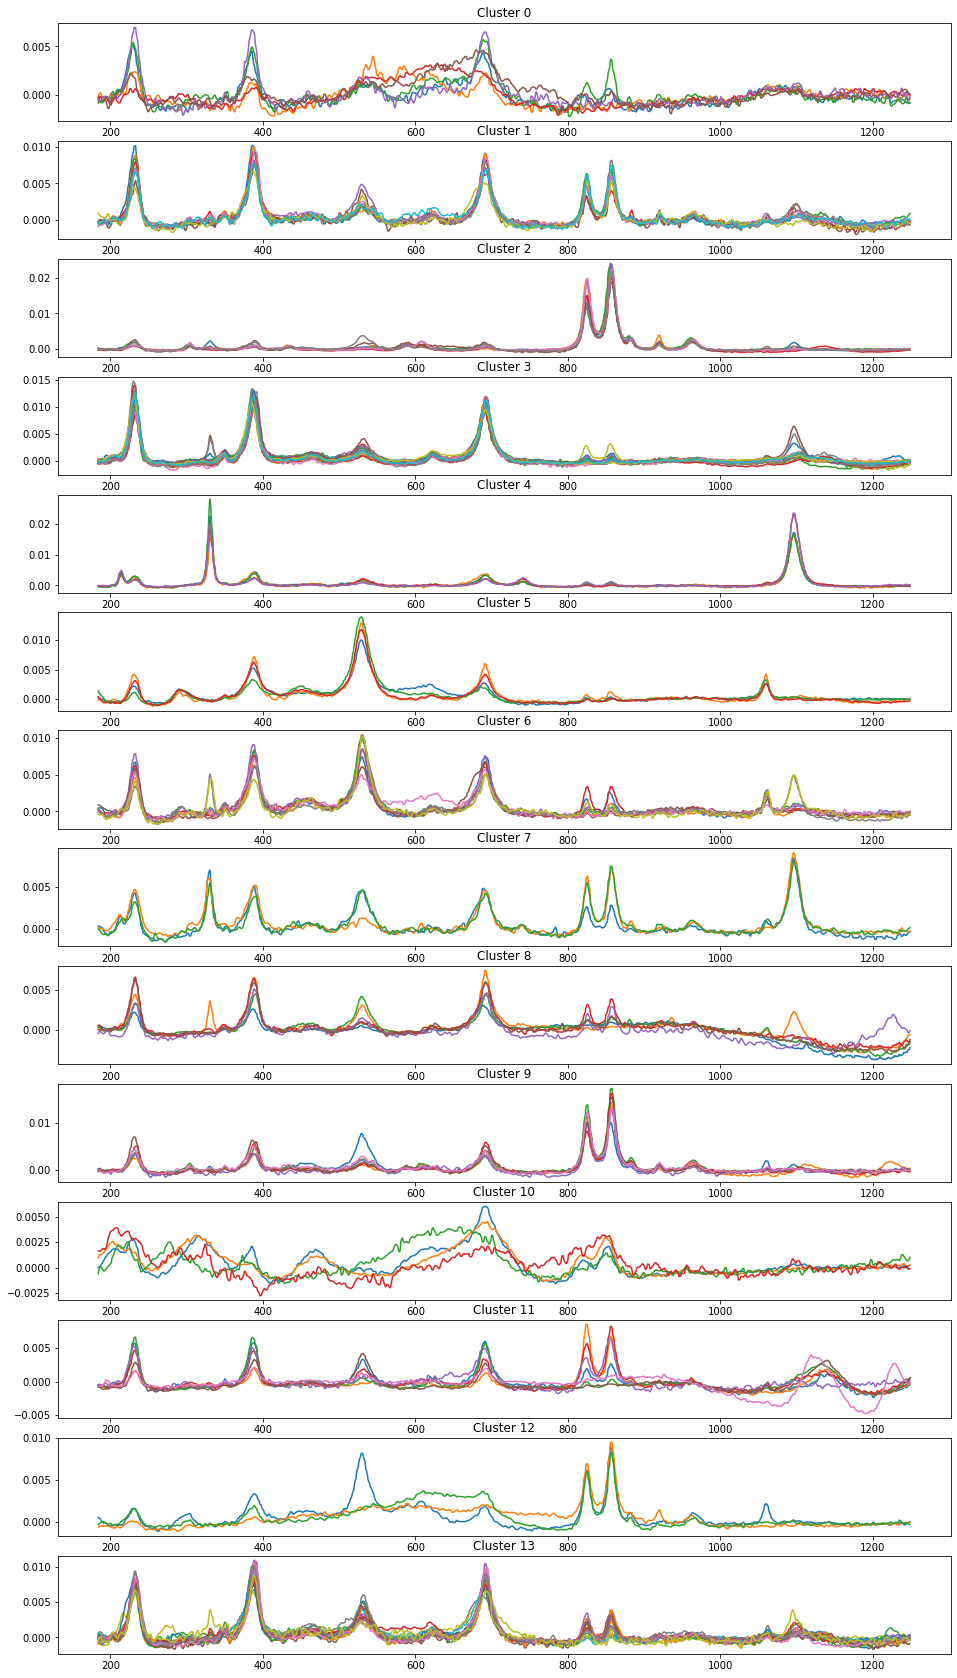

In [18]:
fig2, axs2 = plt.subplots(len(np.unique(label)),figsize = (16,30))

for i in enumerate(np.unique(label)):
    for temp in enumerate(label):
        if temp[1]==i[1]:
            axs2[i[0]].plot(data.wn,data[names[temp[0]+1]])
            axs2[i[0]].set_title('Cluster ' + str(i[1]))

### Metodo della derivata seconda

In [19]:
def second_derivative(x,y,x0):
    k = np.where(x == x0)
    out = (y[k+1]-2*y[k]+y[k-1])/(x[k]-x[k-1]) 

Di questo teniamo i centroidi, con i quali fitteremo gli spettri puri. I centroidi sono i seguenti:

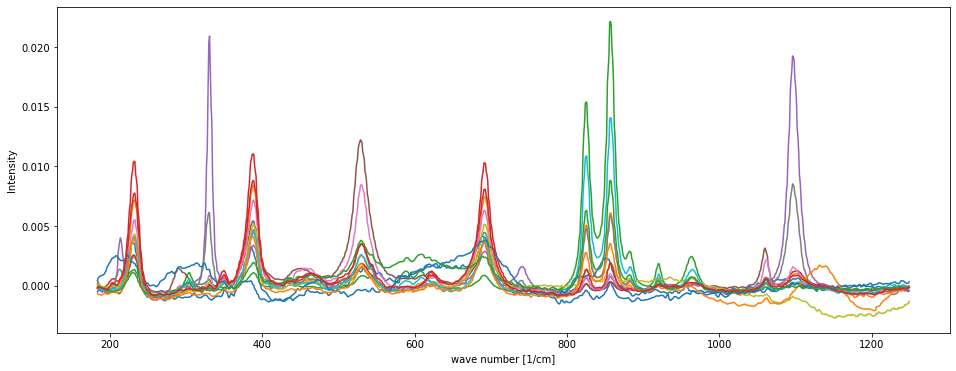

In [20]:
raman_plot()
for temp in np.unique(label):
    plt.plot(data.wn,cluster_KM.cluster_centers_[temp])

Salviamo infine i centroidi

In [21]:
# genero un pandas dataframe
centres=pd.DataFrame(data.wn.copy())
i=0
for i in range(len(np.unique(label))):
    centres=centres.join(pd.DataFrame(cluster_KM.cluster_centers_[i],columns=[str(i)]))
centres

,wn,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,184.0,-0.000507,-0.000197,-0.000022,-0.000228,-1.772655e-04,0.000425,0.000181,1.721492e-04,0.000150,-0.000177,0.000507,-0.000668,-0.000100,-0.000155
1,185.0,-0.000359,-0.000224,-0.000007,-0.000169,-2.155016e-04,0.000226,0.000117,9.756678e-05,0.000154,-0.000145,0.000671,-0.000703,-0.000055,-0.000119
2,186.0,-0.000349,-0.000236,-0.000012,-0.000159,-2.325358e-04,0.000162,0.000086,5.995975e-05,0.000135,-0.000146,0.000725,-0.000723,-0.000061,-0.000123
3,187.0,-0.000355,-0.000230,-0.000024,-0.000148,-2.466317e-04,0.000064,0.000029,2.595913e-07,0.000100,-0.000165,0.000790,-0.000744,-0.000075,-0.000131
4,188.0,-0.000412,-0.000184,-0.000050,-0.000141,-2.508568e-04,-0.000088,-0.000075,-9.934144e-05,0.000030,-0.000233,0.000860,-0.000761,-0.000110,-0.000149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1245.0,-0.000111,-0.000225,-0.000119,-0.000255,4.566245e-07,-0.000196,-0.000298,-4.019136e-04,-0.001587,-0.000046,0.000237,-0.000240,-0.000109,-0.000273
1062,1246.0,-0.000325,-0.000196,-0.000099,-0.000243,-4.062008e-05,-0.000194,-0.000291,-3.264139e-04,-0.001541,-0.000072,0.000204,-0.000159,-0.000112,-0.000214
1063,1247.0,-0.000474,-0.000175,-0.000083,-0.000225,-6.562844e-05,-0.000183,-0.000275,-2.525871e-04,-0.001483,-0.000076,0.000203,-0.000086,-0.000112,-0.000161
1064,1248.0,-0.000468,-0.000175,-0.000080,-0.000209,-5.929300e-05,-0.000164,-0.000257,-2.199557e-04,-0.001470,-0.000059,0.000239,-0.000065,-0.000103,-0.000145


In [24]:
centres.to_csv("../data/processed/CLUSTERING_data_centres.csv")
np.savetxt("../data/processed/CLUSTERING_weights.txt",label)